In [3]:
%pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.1 MB/s eta 0:00:00


Using cache found in /root/.cache/torch/hub/isl-org_ZoeDepth_main


img_size [384, 512]


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_NK.pt
Loaded successfully


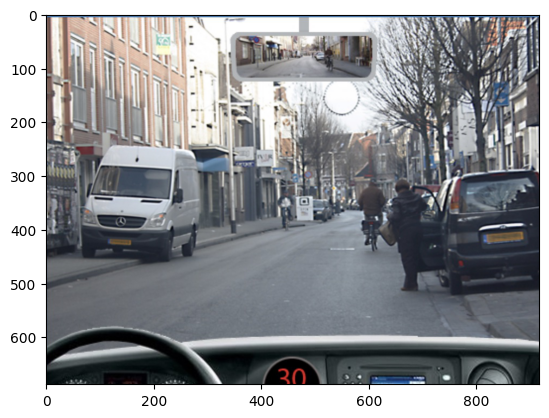

Saved raw depth to /content/drive/MyDrive/ZOE probeersels/Test.png


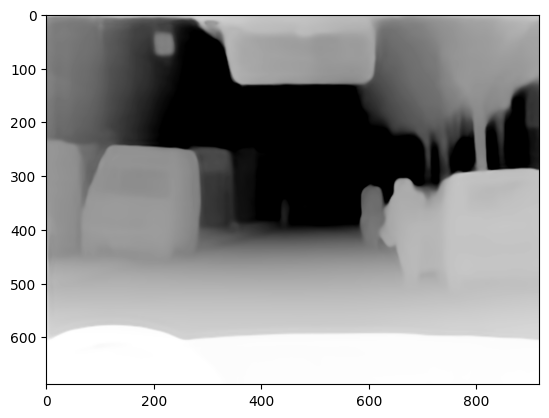

Pixel color at (428.9238739013672, 82.44350242614746): (162, 162, 162, 255)
car
close
Pixel color at (681.7129516601562, 138.43428802490234): (105, 105, 105, 255)
traffic sign
medium far
Pixel color at (421.0333709716797, 217.7651596069336): (0, 0, 0, 255)
traffic sign
Pixel color at (421.11260986328125, 227.9797592163086): (0, 0, 0, 255)
traffic sign
Pixel color at (683.3613586425781, 221.74765014648438): (41, 41, 41, 255)
traffic sign


In [18]:

import torch
import matplotlib.pyplot as plt
from PIL import Image

repo = "isl-org/ZoeDepth"
#torch.hub.help("intel-isl/MiDaS", "DPT_BEiT_L_384", force_reload=True)

# Zoe_K
#model_zoe_k = torch.hub.load(repo, "ZoeD_K", pretrained=True)

# Zoe_NK
model_zoe_nk = torch.hub.load(repo, "ZoeD_NK", pretrained=True)

##### sample prediction
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
zoe = model_zoe_nk.to(DEVICE)

# Local file
image = Image.open("/content/drive/MyDrive/ZOE probeersels/Images/Stad_1.jpeg").convert("RGB")  # load
depth_numpy = zoe.infer_pil(image)  # as numpy
plt.imshow(image)
plt.show()

depth_pil = zoe.infer_pil(image, output_type="pil")  # as 16-bit PIL Image

depth_tensor = zoe.infer_pil(image, output_type="tensor")  # as torch tensor

# Tensor 
from zoedepth.utils.misc import pil_to_batched_tensor
X = pil_to_batched_tensor(image).to(DEVICE)
depth_tensor = zoe.infer(X)

#image = get_image_from_url(URL)  # fetch
depth = zoe.infer_pil(image)

# Save raw
from zoedepth.utils.misc import save_raw_16bit
fpath = "/content/drive/MyDrive/ZOE probeersels/Test.png"
save_raw_16bit(depth, fpath)

# Colorize output
from zoedepth.utils.misc import colorize

colored = colorize(depth)

# save colored output
Image.fromarray(colored).save("/content/drive/MyDrive/ZOE probeersels/Test_colored.png")

# display image
image = Image.open("/content/drive/MyDrive/ZOE probeersels/Test_colored.png")
plt.imshow(image)
plt.show()


from PIL import Image
import csv

# Load image
img = Image.open("/content/drive/MyDrive/ZOE probeersels/Test_colored.png")
width, height = img.size

# Open CSV file
with open("/content/drive/MyDrive/ZOE probeersels/CSV/dataframe_voor_depth_16.csv", "r") as csvfile:
    reader = csv.DictReader(csvfile)

    # Iterate through each row in the CSV file
    for row in reader:
        # Retrieve normalized x and y coordinates from CSV file
        x = float(row["x_midden"])
        y = float(row["y_midden"])

        # Get the actual pixel coordinates by multiplying with image dimensions
        #x = int(x_norm * width)
       # y = int(y_norm * height)

        if 0 <= x < width and 0 <= y < height:

         # Get the color of the pixel at the specified coordinate
          pixel_color = img.getpixel((x, y))

         # Print the pixel color
          print(f"Pixel color at ({x}, {y}): {pixel_color}")

          classes = row["class_naam"]
          print(classes)

          closeness = pixel_color[0]
          if 151 > closeness > 100: 
            distance = "medium far"
          elif 51 < closeness < 150:
            distance = "far"
          elif closeness < 50:
            continue
          else: 
            distance = "close"

          print(distance)
        
        else:
          print("Pixel coordinates are out of bounds")